In [1]:
# Bloques basicos
import sionna
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Parametros basicos
sionna.phy.config.seed = 0 # semilla aleatoria
N = 128 # longitud del código
K = 64 # número de bits de información
lote_prueba = 200 # tamaño del batch
snr_prueba = 10.0 # SNR en dB para la simulación de prueba
bitsxsimb = 1 # bits por símbolo (BPSK)
if bitsxsimb == 1:
    modulacion = "pam" # +1+0j y -1+0j para BPSK
else:
    modulacion = "qam" # QAM para más bits por símbolo
bloq_inter = 64 # Numero de bloques de interleaving (1 = sin interleaving)
list_scl = 8 # tamaño de lista para decodificador SCL
LLR_clip = 1000 # valor de recorte para LLRs
canal = "awgn" # posibles valores: "awgn", "rayleigh"

# Clases comunes
datos = sionna.phy.mapping.BinarySource() # generador de datos aleatorios
constelacion = sionna.phy.mapping.Constellation(modulacion, bitsxsimb) # define la constelacion
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion) # bits a simbolos
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion) # inverso del mapeador
interleaver = sionna.phy.fec.interleaving.RandomInterleaver(axis=1) # interleaver a nivel de bloq_inter
deinterleaver = sionna.phy.fec.interleaving.Deinterleaver(interleaver) # inverso del interleaver

2026-01-18 10:05:54.476628: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-18 10:05:54.486109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768748754.495466   38838 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768748754.498161   38838 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768748754.505467   38838 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

b: tf.Tensor([[0. 0. 0.]], shape=(1, 3), dtype=float32)
x: tf.Tensor([[1.+0.j 1.+0.j 1.+0.j]], shape=(1, 3), dtype=complex64)
y: tf.Tensor([[0.6684856+0.10039947j 0.8111797+0.20025137j 1.6621847+0.02388705j]], shape=(1, 3), dtype=complex64)
b_hat: tf.Tensor([[0. 0. 0.]], shape=(1, 3), dtype=float32)
err: 2


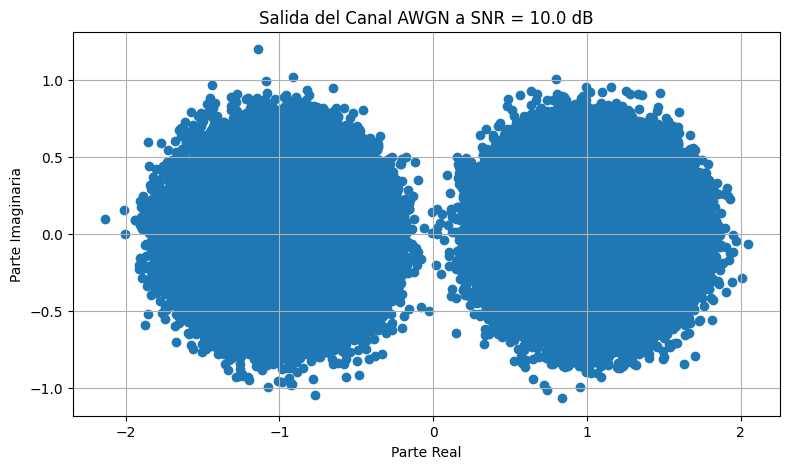

In [3]:
# Simulacion AWGN sin codigo de canal

# Transmision
b = datos([lote_prueba, bloq_inter, K])
x = mapeador(b)

# Canal AWGN
no = sionna.phy.utils.ebnodb2no(snr_prueba, bitsxsimb, coderate=1.0)
awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
awgn = tf.complex(awgn_real, awgn_imag)
y = x + awgn

# Recepcion
llr = demapeador(y, no)
b_hat = sionna.phy.utils.hard_decisions(llr)

# Grafico de y
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Salida del Canal AWGN a SNR = {} dB'.format(snr_prueba))
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

# Prueba de variables y errores
dim_hor = 3 # numero de bits de bloque
dim_ver = 1 # numero de bloques de interleaving
print("b:", b[0, :dim_ver, :dim_hor])
print("x:", x[0, :dim_ver, :dim_hor])
print("y:", y[0, :dim_ver, :dim_hor])
print("b_hat:", b_hat[0, :dim_ver, :dim_hor])
err = tf.math.count_nonzero(tf.not_equal(b, b_hat), dtype=tf.int32)
print("err:", int(err.numpy()))

b: tf.Tensor([[1. 1. 1.]], shape=(1, 3), dtype=float32)
x: tf.Tensor([[1.+0.j 1.+0.j 1.+0.j]], shape=(1, 3), dtype=complex64)
y: tf.Tensor([[0.4087463 +0.8348257j  0.08356299+0.86024505j 0.17239463+0.95755684j]], shape=(1, 3), dtype=complex64)
b_hat: tf.Tensor([[1. 1. 1.]], shape=(1, 3), dtype=float32)
err: 19831


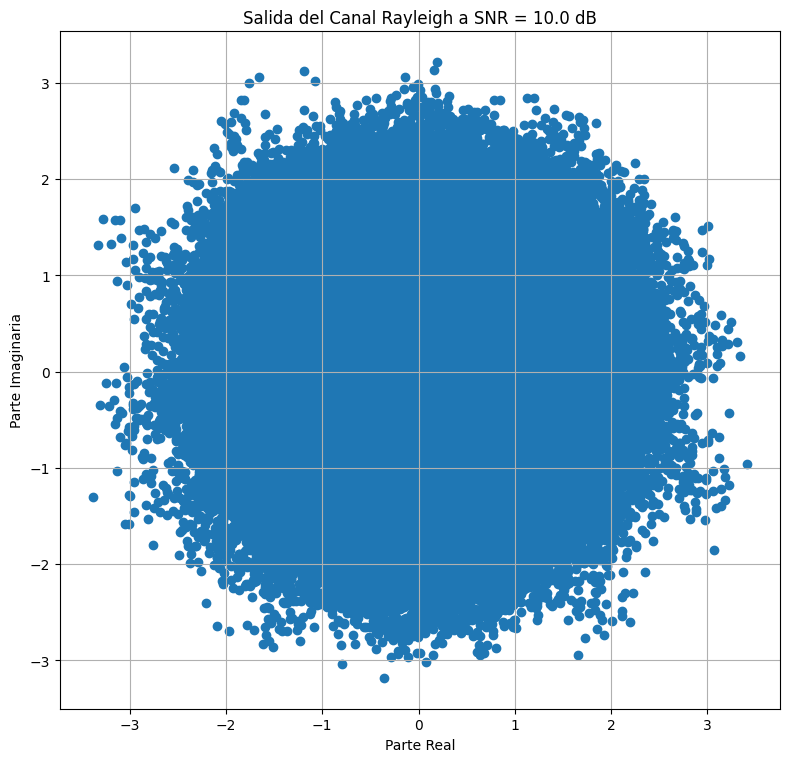

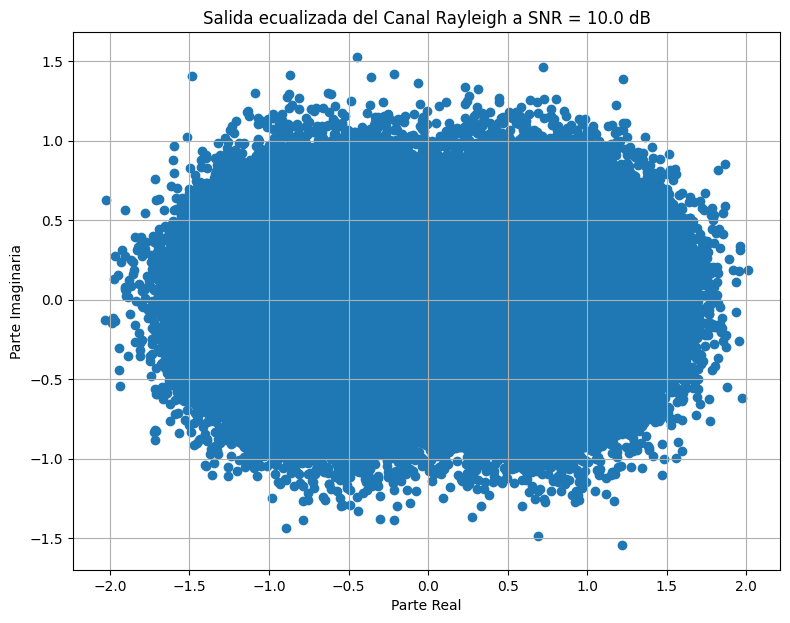

In [4]:
# Prueba el correcto funcionamiento del sistema con canal Rayleigh

# Transmision
b = datos([lote_prueba, bloq_inter, K]) # otra opcion contra el desvanecimiento plano es usar diversidad
b_int = interleaver(b)
x = mapeador(b_int)

# Canal Rayleigh con desvanecimiento plano en N
no = sionna.phy.utils.ebnodb2no(snr_prueba, bitsxsimb, coderate=1.0) # sin codigo de canal
awgn_real = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
awgn_imag = sionna.phy.config.tf_rng.normal(tf.shape(x), mean=0.0 ,stddev=tf.sqrt(no/2.0))
awgn = tf.complex(awgn_real, awgn_imag) # desviacion estandar no
h_real = sionna.phy.config.tf_rng.normal([lote_prueba, bloq_inter], stddev=tf.sqrt(0.5), dtype=tf.float32)
h_imag = sionna.phy.config.tf_rng.normal([lote_prueba, bloq_inter], stddev=tf.sqrt(0.5), dtype=tf.float32)
h = tf.complex(h_real, h_imag) # desviacion estandar 1
y = tf.expand_dims(h, -1) * x + awgn

# Recepcion (con eualizacion MMSE)
mmse = tf.math.conj(h) / tf.cast(tf.math.square(tf.abs(h)) + no, tf.complex64)
y_eq = tf.expand_dims(mmse, -1) * y
no_eff = no * tf.math.square(tf.abs(mmse))
llr = demapeador(y_eq, tf.expand_dims(no_eff, -1))
llr_deint = deinterleaver(llr)
b_hat = sionna.phy.utils.hard_decisions(llr_deint)

# Grafico de y
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Salida del Canal Rayleigh a SNR = {} dB'.format(snr_prueba))
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

# Grafico de y ecualizado
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Salida ecualizada del Canal Rayleigh a SNR = {} dB'.format(snr_prueba))
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.scatter(tf.math.real(y_eq), tf.math.imag(y_eq))
plt.tight_layout()

# Prueba de variables y errores
dim_hor = 3 # numero de bits de bloque
dim_ver = 1 # numero de bloques de interleaving
print("b:", b[0, :dim_ver, :dim_hor])
print("x:", x[0, :dim_ver, :dim_hor])
print("y:", y[0, :dim_ver, :dim_hor])
print("b_hat:", b_hat[0, :dim_ver, :dim_hor])
err = tf.math.count_nonzero(tf.not_equal(b, b_hat), dtype=tf.int32)
print("err:", int(err.numpy()))